In [1]:
import os

device = "cuda:0"
os.environ["TORCH_HOME"] = "/data/amathur-23/ROB313/"

In [9]:
from models import ResNetBinaryClassifier
import torch

backbone = "resnet50"

projection_path = (
    f"/data/amathur-23/ROB313/models/classifier_trial_{backbone}/latest_model_7eps.pth"
)

model = ResNetBinaryClassifier(backbone=backbone)
model.load_state_dict(torch.load(projection_path))
model = model.to(device)
# model.load_state_dict(torch.load(projection_path))

Using resnet50 with 2048 FC input features


In [10]:
from utils.datasets import WildfireDataset

dataset = WildfireDataset("/data/amathur-23/ROB313", split="test")

loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

Loading meta file: /data/amathur-23/ROB313/test.csv


In [11]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()


# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Iterate over the data in the loader

all_preds = []
all_labels = []
all_mid_ids = []


for batch in tqdm(loader):
    images = batch["image"]
    labels = batch["label"]
    with torch.no_grad():
        outputs = model(images.to(device))
    preds = torch.round(torch.sigmoid(outputs)).squeeze()

    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels)

    # Find indices where prediction does not match the label
    mismatch_indices = (preds != labels).nonzero()[0]
    all_mid_ids.extend(mismatch_indices)

100%|██████████| 394/394 [00:37<00:00, 10.51it/s]


In [12]:
len(all_mid_ids), len(all_labels), len(all_preds)

(763, 6299, 6299)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

print(cm)

[[2060  760]
 [   3 3476]]


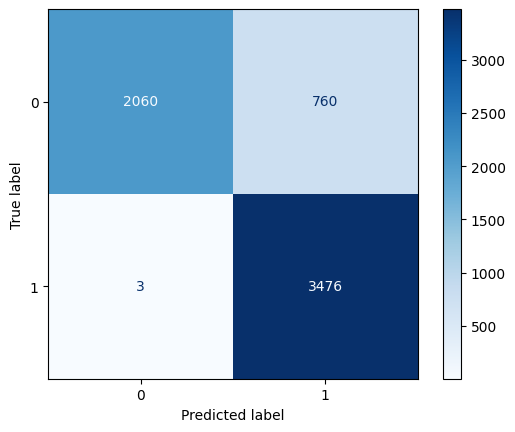

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
from sklearn.metrics import f1_score

accuracy = np.sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
print(f"Accuracy: {accuracy}")

f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1}")

Accuracy: 0.8788696618510875
F1 Score: 0.901101749837978
